# 1. Introduction

This report details the approach taken for the "Histopathologic Cancer Detection" Kaggle competition, a binary image classification challenge. The objective is to accurately identify metastatic cancer tissue in small, 96x96 pixel image patches, each containing 3 color channels.

The dataset for this competition comprises a total of 220,025 labeled images, which were split into 176,020 images for training and 44,005 images for validation. Additionally, 57,458 unlabeled images are provided for final classification in the competition. The primary evaluation metric for this challenge is the Area Under the Receiver Operating Characteristic Curve (AUC).

For processing, a batch size of 32 was selected for model training and evaluation.

You can find the code for this challenge in the following repository: https://github.com/jjzd83/IDL-Wk3

## 1.1 Code for loading the data

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau

import keras_tuner as kt
import matplotlib.pyplot as plt

import seaborn as sns

import re
import unicodedata

# paden configureren
image_dir = 'train/'
labels_csv_path = 'train_labels.csv'
image_size = (96, 96) 
batch_size = 32
num_classes = 2 

2025-06-30 16:43:31.560163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-30 16:43:31.582263: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-30 16:43:31.589410: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 1. labels inlezen
try:
    labels_df = pd.read_csv(labels_csv_path)
    print(f"labels ingelezen. aantal rijen: {len(labels_df)}")
    print("voorbeeld labels:")
    print(labels_df.head())
except FileNotFoundError:
    print(f"fout: {labels_csv_path} niet gevonden.")
    exit()

labels_df['image_name'] = labels_df['id'].astype(str) + '.tif'

datagen = ImageDataGenerator(
    rescale=1./255, # normaliseren van pixelwaarden naar [0, 1]
    validation_split=0.2 # percentage voor validatie dataset
)

labels ingelezen. aantal rijen: 220025
voorbeeld labels:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


In [3]:
# 3. trainings- en validatiedata genereren
# gebruik .flow_from_dataframe voor het koppelen van filenames aan labels
train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=image_dir,
    x_col='image_name',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw', # 'raw' voor numerieke labels, 'categorical' voor one-hot encoded
    subset='training',
    shuffle=True,
    interpolation='nearest' # of 'bilinear'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=image_dir,
    x_col='image_name',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw', # 'raw' voor numerieke labels, 'categorical' voor one-hot encoded
    subset='validation',
    shuffle=False, # shuffle niet voor validatie
    interpolation='nearest'
)


print(f"\ntrainingsdata batches: {len(train_generator)}")
print(f"validatiedata batches: {len(validation_generator)}")

Found 176020 validated image filenames.
Found 44005 validated image filenames.

trainingsdata batches: 5501
validatiedata batches: 1376


# 2. Exploratory Data Analysis 

Exploratory Data Analysis was conducted to gain a foundational understanding of the dataset's characteristics, identify any potential biases or anomalies, and inform subsequent decisions regarding model architecture and preprocessing. The primary focus was on the distribution of classes, visual characteristics of the images, and the underlying pixel intensity distributions.

## 2.1 Class Distribution Analysis

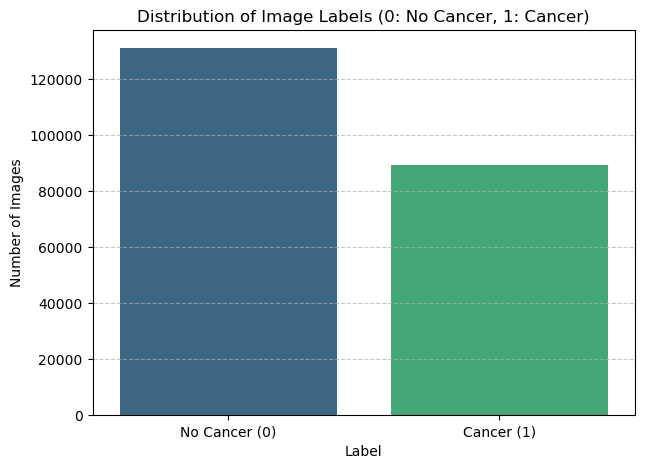

In [4]:
labels_df = pd.read_csv(labels_csv_path)
class_counts = labels_df['label'].value_counts()

# Create the bar chart
plt.figure(figsize=(7, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis', hue=class_counts.index,legend=False)

# Add labels and title for readability
plt.title('Distribution of Image Labels (0: No Cancer, 1: Cancer)')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.xticks(ticks=[0, 1], labels=['No Cancer (0)', 'Cancer (1)']) # Explicit labels for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The initial analysis of the dataset revealed a relatively balanced distribution with 40.5% of the samples being positive. This relatively even distribution simplifies the initial model training, as specialized techniques for handling class imbalance may not be immediately necessary. The precise counts are visualized in the bar chart above.

## 2.2 Sample Image Visualizations

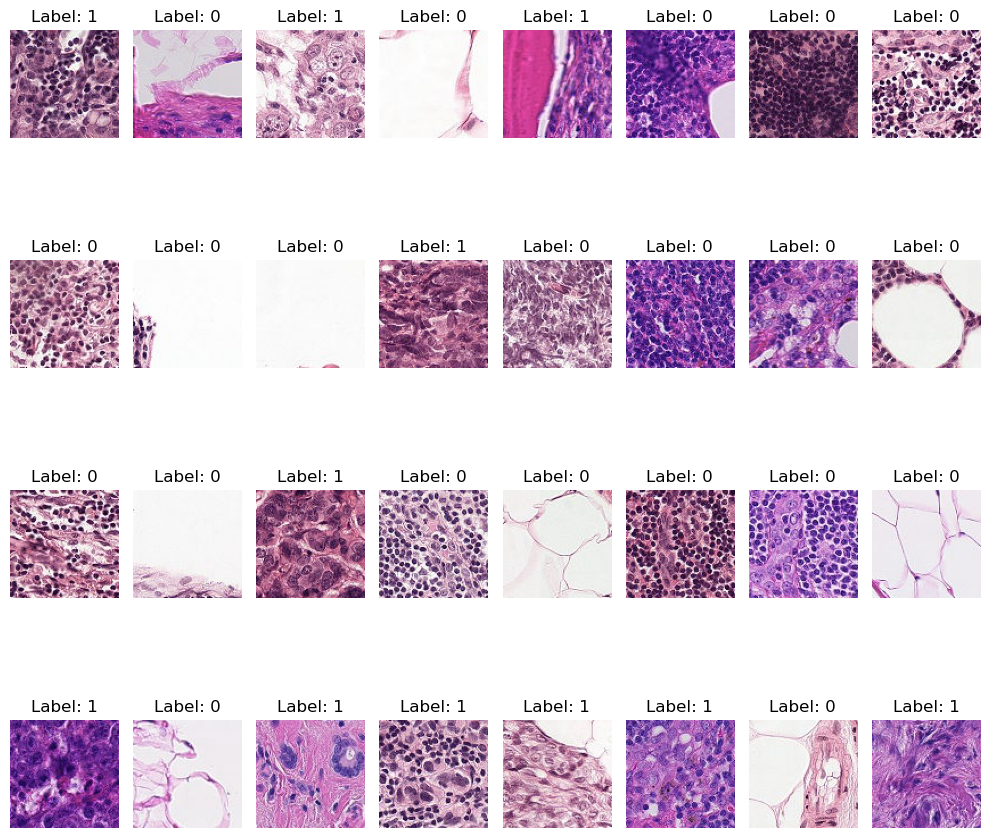

In [5]:
images, labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(len(images)):
    plt.subplot(4, 8, i + 1)
    plt.imshow(images[i])
    label_name = labels[i] 
    plt.title(f"Label: {label_name}")
    plt.axis('off')
plt.tight_layout()
plt.show()

A selection of sample images from both non-cancerous and cancerous classes was visualized. While an untrained eye may not discern definitive patterns or diagnoses from individual image patches, subtle differences in color and structural patterns were noted between the classes. These preliminary visual inspections confirm the format and nature of the image data but highlight the challenge of manual classification for this task.

## 2.3 Channel Mean and Pixel Intensity Distribution Analysis

Processing 70 batches...


<Figure size 1200x700 with 0 Axes>

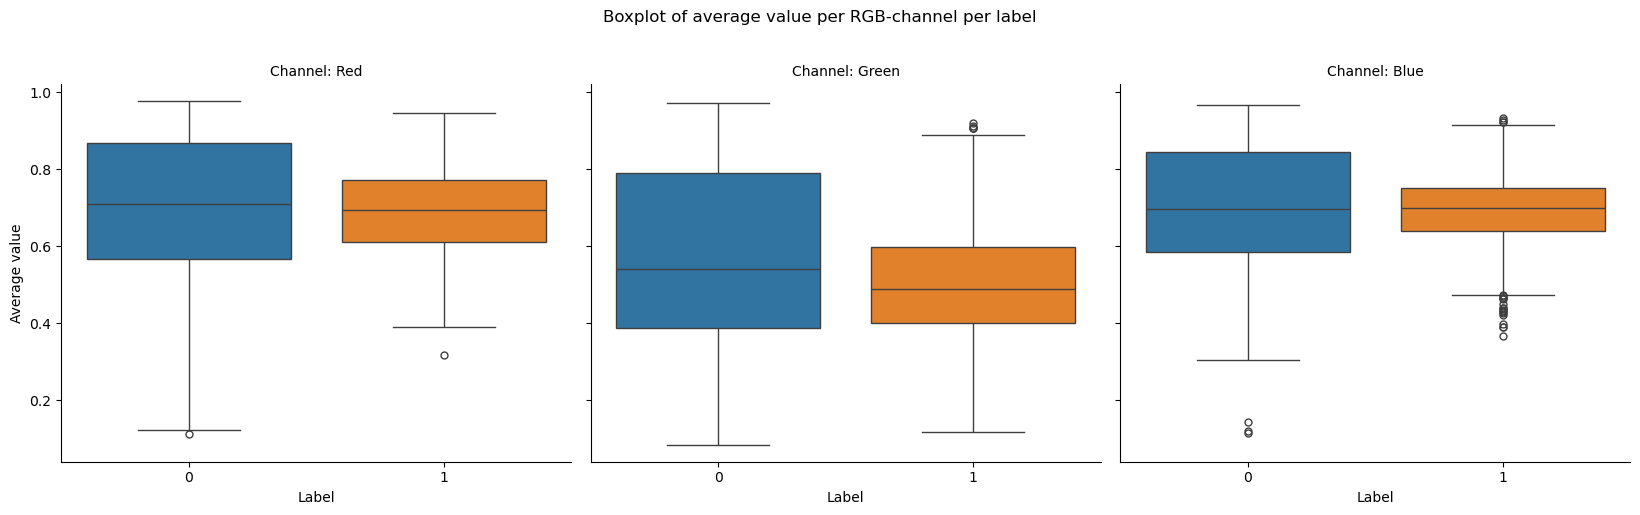

In [6]:
def extract_channel_means(images_batch, labels_batch, channel_names):
    mean_per_channel_per_image = np.mean(images_batch, axis=(1, 2))
    df_batch = pd.DataFrame(mean_per_channel_per_image, columns=channel_names)
    df_batch['label'] = labels_batch
    return df_batch

all_batches_data = []
num_batches_to_process = 70
channel_names = ['Red', 'Green', 'Blue']

print(f"Processing {num_batches_to_process} batches...")
for i in range(num_batches_to_process):
    try:
        images_batch, labels_batch = next(train_generator)
        batch_df = extract_channel_means(images_batch, labels_batch, channel_names)
        all_batches_data.append(batch_df)
    except StopIteration:
        print(f"Generator is empty after {i} batches.")
        break

if all_batches_data:
    full_df = pd.concat(all_batches_data, ignore_index=True)
    df_melted_full = full_df.melt(id_vars=['label'], var_name='kanaal', value_name='gemiddelde_waarde')

    plt.figure(figsize=(12, 7)) 
    g = sns.catplot(data=df_melted_full, x='label', y='gemiddelde_waarde', col='kanaal',
                    kind='box', height=5, aspect=1.1, col_wrap=3,
                    hue='label',           
                    legend=False)          
    
    # Stel titels en labels in
    g.set_axis_labels("Label", "Average value")
    g.set_titles("Channel: {col_name}") 
    plt.suptitle('Boxplot of average value per RGB-channel per label', y=1.02) 
    
    plt.tight_layout() 
    plt.show()
else:
    print("Geen data verwerkt van de generator.")

In [ ]:
def extract_all_channel_pixels(images_batch, labels_batch, channel_names):
    all_pixels_data = []
    # Loop through each image in the batch
    for i, img in enumerate(images_batch):
        label = labels_batch[i]
        for c_idx, c_name in enumerate(channel_names):
            # Flatten the channel data for this image and add to list
            # Each entry: [pixel_value, channel_name, label]
            for pixel_value in img[:, :, c_idx].flatten():
                all_pixels_data.append([pixel_value, c_name, label])
    return pd.DataFrame(all_pixels_data, columns=['pixel_value', 'channel', 'label'])

# --- Data Collection from Generator (similar to your box plot approach) ---
all_batches_pixel_data = []
channel_names = ['Red', 'Green', 'Blue']
num_batches_to_process = 25

print(f"Collecting pixel data from {num_batches_to_process} batches for histograms...")

for i in range(num_batches_to_process):
    try:
        images_batch, labels_batch = next(train_generator)
        # Ensure labels_batch is a flat array/list if not already
        if hasattr(labels_batch, 'numpy'): # For TensorFlow/Keras datasets
             labels_batch = labels_batch.numpy().flatten()
        elif hasattr(labels_batch, 'flatten'):
            labels_batch = labels_batch.flatten()

        batch_pixel_df = extract_all_channel_pixels(images_batch, labels_batch, channel_names)
        all_batches_pixel_data.append(batch_pixel_df)
    except StopIteration:
        print(f"Generator is empty after {i} batches. Collected data from {i} batches.")
        break
    except Exception as e:
        print(f"Error processing batch {i}: {e}")
        break

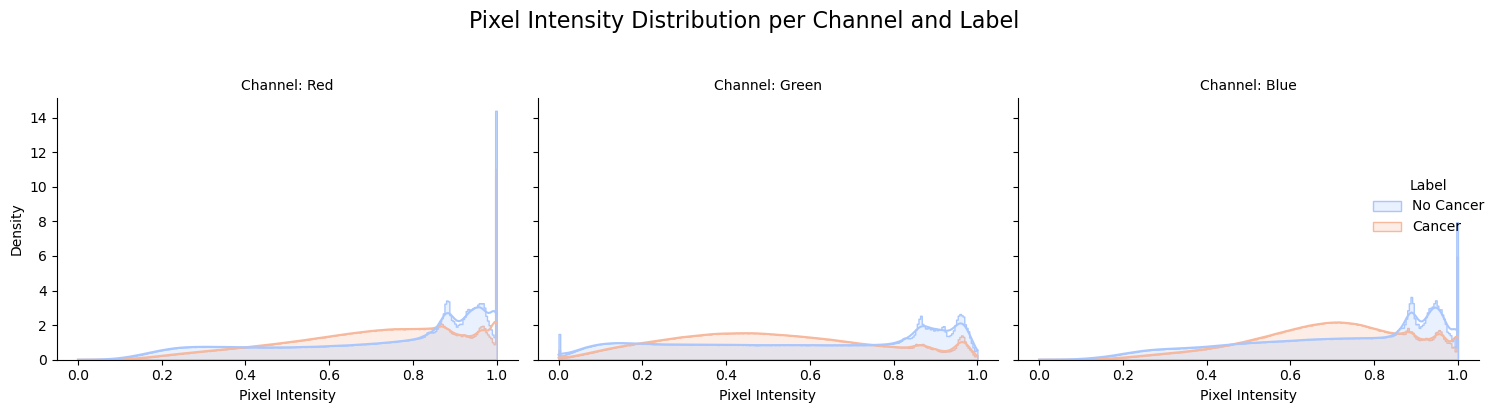

In [8]:
if all_batches_pixel_data:
    full_pixel_df = pd.concat(all_batches_pixel_data, ignore_index=True)

    # --- Plotting Pixel Intensity Histograms with sns.displot ---
    # sns.displot is a figure-level function designed for faceted distribution plots.
    # It handles the FacetGrid creation and legend more automatically.
    g = sns.displot(data=full_pixel_df, x='pixel_value', hue='label', col='channel',
                    kind='hist',            
                    bins=256, kde=True,     
                    palette='coolwarm', stat='density', common_norm=False,
                    element="step", fill=True,
                    height=4, aspect=1.2    
                   )

    # Set titles for each subplot
    g.set_titles("Channel: {col_name}")
    g.set_axis_labels("Pixel Intensity", "Density")

    # Add a main title for the entire figure
    plt.suptitle('Pixel Intensity Distribution per Channel and Label', y=1.02, fontsize=16)

    new_labels = ['No Cancer', 'Cancer']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    g._legend.set_title("Label")


    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent suptitle overlap
    plt.show()
else:
    print("No pixel data processed from the generator.")

To gain deeper insights into the image characteristics beyond visual inspection, a detailed analysis of pixel intensities per channel was performed.

* Average Channel Values: By calculating the average pixel intensity for each Red, Green, and Blue channel across a sample of images and plotting their distribution via box plots, a notable distinction emerged. It was observed that non-cancerous images (label 0) consistently exhibit a higher average pixel intensity in the green channel compared to cancerous images (label 1). This finding suggests a potential spectral difference in the tissue morphology or background characteristics between the two classes. See the figure with box plots above.

* Full Pixel Intensity Histograms: Further analysis involved generating density histograms of individual pixel intensities across the full 0-255 range for each channel, separated by class. These "area curves" provide a comprehensive view of the pixel value distributions. The distributions for all channels cover the expected full range of 0-255, without significant truncation or spikes, indicating a high quality of the raw image data. The histograms also visually reinforce the observation from the box plots regarding the difference in the green channel's intensity distribution between the two labels, where the non-cancerous samples show a greater density of higher green pixel values.

## 2.4 Data Quality Conclusion
Based on the exploratory analysis, including checks on class distribution, image integrity, and pixel value ranges, the dataset appears to be of high quality. No significant data corruption, missing values, or outliers requiring extensive manual cleaning were identified. This suggests that the primary preprocessing steps will involve standard image normalization techniques, rather than complex data purification procedures.

# 3 Analysis: Model Building and Training

## 3.1 General Model Building Approach & Iteration Strategy

Identifying an optimal model architecture for this task necessitated an iterative experimental approach. To accurately assess the impact of each modification and guide subsequent development, it was crucial to standardize the training and evaluation methodology across all model variations.

This was achieved by implementing a modular system where model architectures and their respective parameters were defined in a dictionary. Each individual model was then trained and evaluated uniformly. This systematic approach facilitated consistent result storage and future comparative analysis. Given that each model training run required approximately 45 minutes, this standardized framework also enabled efficient scheduling and execution of multiple experiments.

Instead of drawing from the course material, a Keras Functional API approach was adopted for constructing the models, rather than a sequential configuration. This methodology allowed for abstraction of general model components and flexible isolation of specific building blocks. This design inherently supports parameterization, enabling straightforward modification or addition of similar structural elements across different architectural iterations.

In [ ]:

def get_filesystem_safe_name(name: str, max_length: int = 255) -> str:

    name = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8')
    name = re.sub(r'[^\w\s-]', '_', name)
    
    name = re.sub(r'\s+', '_', name)
    name = re.sub(r'__+', '_', name)
    
    name = name.strip('_-.')
    name = name.lower()

    if len(name) > max_length:
        name = name[:max_length]
        name = name.strip('_-.')

    if not name:
        return "default_name"

    return name

def get_full_model_name(model_config: dict) -> str:

    parts = []
    
    if name := model_config.get('name'):
        parts.append(name)

    if creator_function := model_config.get('creator_function'):
        parts.append(creator_function)

    if params := model_config.get('params'):
        for key, value in params.items():
            parts.append(f"{key}_{value}")

    # Join all parts with an underscore
    full_name_raw = "_".join(parts) if parts else "unnamed_model"
    
    return get_filesystem_safe_name(full_name_raw)

def save_keras_model(model: Model, model_name: str, base_dir: str = "saved_models"):

    # Definieer het pad waar het model moet worden opgeslagen
    save_path = os.path.join(base_dir, f"{model_name}.keras")

    # Zorg ervoor dat de directory bestaat
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Sla het model op
    model.save(save_path)
    print(f"Model '{model_name}' saved as '{save_path}'")
    
def eval_single_model(model,model_name, validation_generator, history):
    print(f"Evaluation of {model_name} on validationset:")
    results = model.evaluate(validation_generator, verbose=1)
    eval_loss = results[0]
    eval_auc = results[1]
    
    print(f"Model '{model_name}' - Validatie Loss: {eval_loss:.4f}, Validatie AUC: {eval_auc:.4f}")
    save_keras_model(model, model_name)
    run_results = {
        'Model Naam': model_name,
        'Beste Validatie Loss (History)': np.min(history.history['val_loss']),
        'Beste Validatie AUC (History)': np.max(history.history['val_auc']),
        'Evaluatie Loss': eval_loss,
        'Evaluatie AUC': eval_auc,
        'Aantal Epochs Getraind': len(history.history['loss'])
    }
    return run_results
    
def present_overall_results(all_results):
    # Presenteer de gecombineerde resultaten in een DataFrame
    results_df = pd.DataFrame(all_results)
    results_df_sorted = results_df.sort_values(by='Evaluatie AUC', ascending=False)
    
    print("\n--- Eindresultaten van Model Vergelijking (gesorteerd op Evaluatie AUC) ---")
    print(results_df_sorted.to_string())
    
    # Optioneel: Sla de resultaten op naar een CSV-bestand
    current_datetime_str = datetime.now().strftime("%Y%m%d_%H%M")
    
    # Sla de resultaten op naar een CSV-bestand met datum en tijd
    output_csv_path = f"model_comparison_results_{current_datetime_str}.csv"
    results_df_sorted.to_csv(output_csv_path, index=False)
    print(f"\nResultaten opgeslagen naar: {output_csv_path}")

def get_log_dir_base(epochs_to_train):
    # When tweaking/test parameters with low epochs, let's keep these attempts out of the tensorboard monitoring
    if epochs_to_train >= 10:
        log_dir_base = "logs/fit/"
    else:
        log_dir_base = "logs/tryout/"
    return log_dir_base
    
def train_multiple_models(models_to_test, train_generator, validation_generator, epochs_to_train = 100):
    log_dir_base = get_log_dir_base(epochs_to_train)
    all_results = [] # Lijst om resultaten van elke run op te slaan
    
    print("Start van de vergelijking van model architecturen...")
    
    for model_config in models_to_test:
        model_name = get_full_model_name(model_config)
        creator_func = model_config['creator_function']
        model_params = model_config['params']
    
        print(f"\n--- Trainen en evalueren van model: {model_name} ---")
    
        # Initialiseer het model
        model = creator_func(
            input_shape=(96, 96, 3),
            num_classes=1,
            model_name=model_name,
            **model_params # Pak de parameters uit de dictionary uit
        )
        
        # Train het model
        print(f"Start training for {model_name}...")
        history = model.fit(
            train_generator,
            epochs=epochs_to_train,
            validation_data=validation_generator,
            callbacks=create_callbacks(model_name=model_name, log_dir_base=log_dir_base),
            verbose=1
        )
        print(f"Training voor {model_name} voltooid.")
        
        run_results= eval_single_model(model,model_name, validation_generator, history)

        all_results.append(run_results)
    
    print("\nAlle modeltrainingen en evaluaties zijn voltooid.")
    present_overall_results(all_results)

# I can now train multiple models like this:

models_to_test = [
        {
        'name': 'Example_building_block_1',
        'creator_function': building_block_1,
        'params': {
            'num_conv_blocks': 3,
            'dense_units': 128,
            'dropout_rate': 0.5
        }
    },
    {
        'name': 'Example_building_block_2',
        'creator_function': building_block_2,
        'params': {
            'num_conv_blocks': 3,
            'dense_units': 128,
            'dropout_rate': 0.95
        }
    },
]

train_multiple_models(models_to_test, train_generator, validation_generator, epochs_to_train = 100)

## 3.2 Common Components: Classification Head & Training Configuration

To isolate and focus on the efficacy of various CNN feature extraction architectures, the classification head remained consistent across all initial model iterations. This head comprises a Dense layer with 128 neurons and an initial dropout rate of 0.5. The final output layer utilises a sigmoid activation function, suitable for binary classification. The dropout rate for this layer was subsequently subject to hyperparameter tuning in later experiments.

For robust model training and performance monitoring, three primary Keras Callbacks were implemented:

* TensorBoard: Utilised for comprehensive tracking of experimental metrics, loss, and model graphs, facilitating effective monitoring and comparison of different training runs.
* EarlyStopping: Configured to halt training when the model's performance on the validation set ceased to improve (i.e., when overfitting began), preventing unnecessary computational expense and ensuring the retention of the best weights.
* ReduceLROnPlateau: Employed to decrease the learning rate if the validation loss stagnates dynamically. This mechanism helps the optimiser escape local minima and fine-tune the model parameters more effectively, preventing overshooting optimal weights.

The Adam optimiser was selected for model compilation, consistent with recommendations from the course material. The models were optimised to minimise binary_crossentropy loss, a standard choice for binary classification tasks, while monitoring the Area Under the Curve (AUC) metric on the validation set for performance evaluation.

In [ ]:
def create_callbacks(model_name, early_stopping_patience=10, reduce_lr_patience=5, log_dir_base = "logs/fit/"):
    
    # Basis log directory voor TensorBoard
    os.makedirs(log_dir_base, exist_ok=True)

    # Creëer een unieke log directory voor elke TensorBoard run
    current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir_current = os.path.join(log_dir_base, f"{model_name}_{current_time}")

    # Definieer Callbacks voor de huidige run
    callbacks = [
        EarlyStopping(
            monitor='val_auc',
            patience=early_stopping_patience, # Geduld voordat training stopt
            mode='max',
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=reduce_lr_patience, # Geduld voordat LR wordt verlaagd
            mode='min',
            min_lr=1e-7,
            verbose=1
        ),
        TensorBoard(
            log_dir=log_dir_current,
            histogram_freq=1,
            write_graph=True
        )
    ]
    return callbacks

def classification_head(input_tensor, num_classes=1, dense_units=128, dropout_rate=0.5):
    x = layers.Flatten(name='flatten')(input_tensor)
    x = layers.Dense(dense_units, activation='relu', name='dense_head')(x)
    x = layers.Dropout(dropout_rate, name='dropout_head')(x)

    # Output laag
    outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)
    return outputs

## 3.3 Initial Architectural Explorations

This section details the initial phase of architectural experimentation, where various convolutional neural network (CNN) designs were evaluated to establish a baseline and identify promising structural components.

### 3.3.1 Baseline: Vanilla CNN

A fundamental CNN architecture was configured to serve as the baseline for performance comparison. This model primarily consists of a series of convolutional blocks, each containing a Conv2D layer followed by a MaxPooling2D layer. The default baseline configuration utilized three such blocks.

In [ ]:
def conv_block_maxpool(input_tensor, filters, name_prefix):
    x = layers.Conv2D(filters, (3, 3), activation='relu', name=f'{name_prefix}_conv')(input_tensor)
    x = layers.MaxPooling2D((2, 2), name=f'{name_prefix}_pool')(x)
    return x

def create_cnn_with_maxpool(input_shape=(96, 96, 3), num_conv_blocks=3,
                            num_classes=1, dense_units=128, dropout_rate=0.5,filters_start = 32, model_name='cnn_maxpool'):

    inputs = keras.Input(shape=input_shape, name='input_layer')
    x = inputs
    
    for i in range(num_conv_blocks):
        current_filters = filters_start * (2 ** i)
        x = conv_block_maxpool(x, current_filters, name_prefix=f'conv_block_{i+1}')

    outputs = classification_head(x, num_classes, dense_units, dropout_rate)
    model = Model(inputs=inputs, outputs=outputs, name=model_name)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

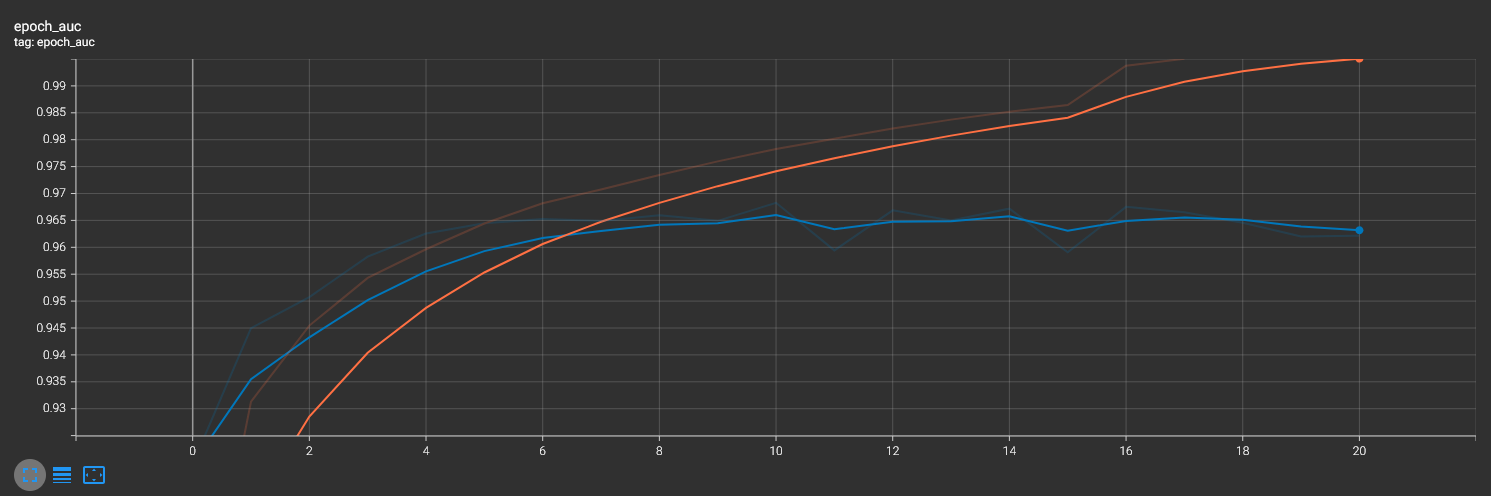

### 3.3.2 Impact of Additional Layers

A subsequent logical step involved extending the network depth by adding an additional convolutional block, resulting in a four-layer architecture. This experiment aimed to assess whether increased model capacity would lead to improved performance on the classification task. 

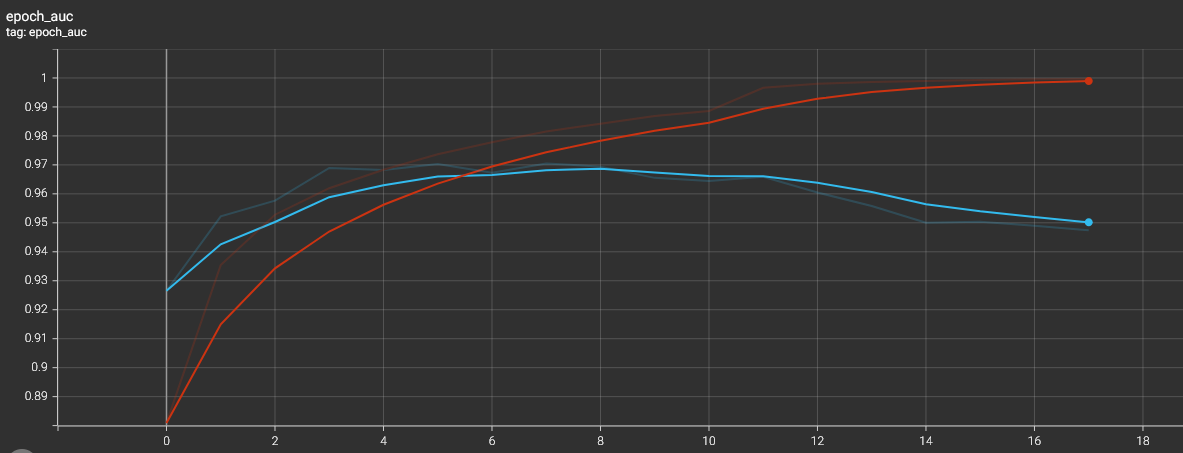

### 3.3.3 Strided Convolutions vs. MaxPooling

Inspired by discussions in the course material, an alternative approach to dimensionality reduction was explored by replacing MaxPooling layers with Conv2D layers utilizing a stride of (2,2). This modification offers the benefit of trainable parameters within the downsampling operation, potentially allowing the network to learn more effective feature aggregation. The architecture maintained three such strided convolutional blocks.

In [ ]:
def conv_block_separate_conv_strides(input_tensor, filters, name_prefix, downsample_strides=(2, 2)):
    # Eerste normale Conv2D laag (geen downsampling)
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same', name=f'{name_prefix}_conv1')(input_tensor)
    # Tweede Conv2D laag met downsampling via strides
    x = layers.Conv2D(filters, (3, 3), strides=downsample_strides, activation='relu', name=f'{name_prefix}_conv_stride_downsample')(x)
    return x

def create_cnn_with_strided_conv_instead_maxpool(input_shape=(96, 96, 3), num_conv_blocks=3,
                                 num_classes=1, dense_units=128, dropout_rate=0.5, strides=(2, 2), model_name='cnn_strided_conv'):
    """
    Maakt een CNN model waarbij downsampling plaatsvindt via strides in de Conv2D lagen.
    Geen aparte MaxPooling lagen.
    """
    inputs = keras.Input(shape=input_shape, name='input_layer')
    x = inputs
    filters_start = 32

    for i in range(num_conv_blocks):
        current_filters = filters_start * (2 ** i)
        x = conv_block_separate_conv_strides(x, current_filters, name_prefix=f'conv_block_{i+1}', downsample_strides=strides)

    outputs = classification_head(x, num_classes, dense_units, dropout_rate)
    model = Model(inputs=inputs, outputs=outputs, name=model_name)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

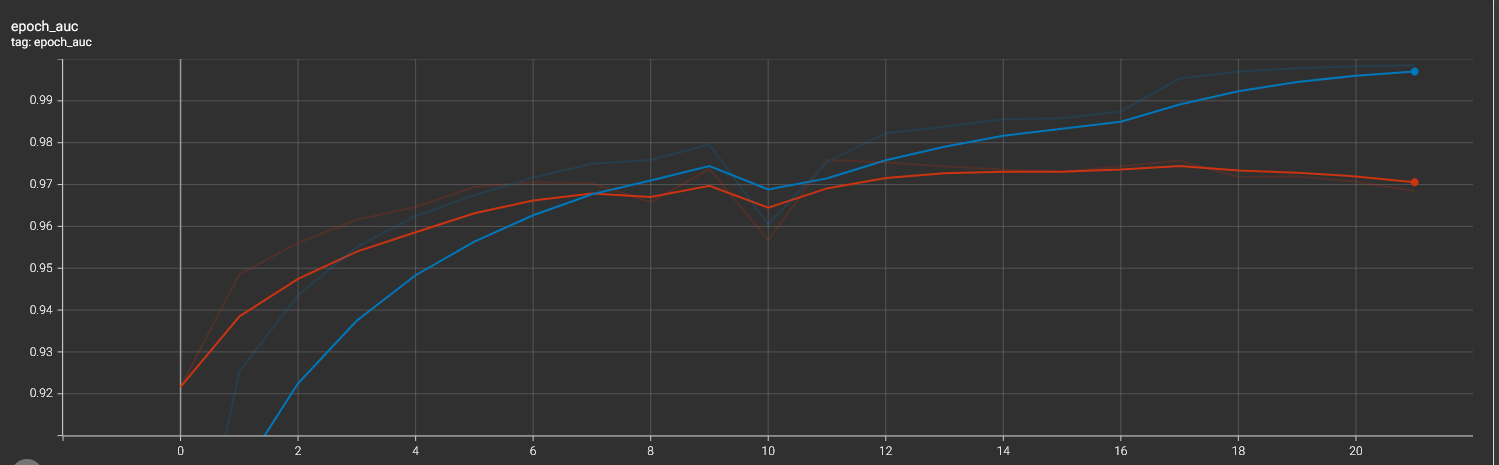

### 3.3.4 Effect of Batch Normalization

Another enhancement suggested in the course material, Batch Normalization, was integrated into the convolutional blocks. Batch Normalization aims to stabilize network training by normalizing layer inputs, which can accelerate convergence and act as a mild regularizer. This modification also utilized a three-block structure. 

In [ ]:
   
def conv_block_batch_norm(input_tensor, filters, name_prefix):
    """
    Maakt een convolutioneel bouwblok met Conv2D, gevolgd door Batch Normalization,
    Activatie en MaxPooling.
    """
    # Conv2D zonder activatie
    x = layers.Conv2D(filters, (3, 3), name=f'{name_prefix}_conv')(input_tensor)
    # Batch Normalization
    x = layers.BatchNormalization(name=f'{name_prefix}_bn')(x)
    # Activatie (bij voorkeur na Batch Normalization)
    x = layers.Activation('relu', name=f'{name_prefix}_relu')(x)
    # MaxPooling
    x = layers.MaxPooling2D((2, 2), name=f'{name_prefix}_pool')(x)
    return x

#AUC: 0.9770
def create_cnn_with_batch_norm(input_shape=(96, 96, 3), num_conv_blocks=3,
                               num_classes=1, dense_units=128, dropout_rate=0.5, model_name='cnn_batch_norm'):

    inputs = keras.Input(shape=input_shape, name='input_layer')
    x = inputs
    filters_start = 32

    for i in range(num_conv_blocks):
        current_filters = filters_start * (2 ** i)
        # Gebruikt de nieuwe conv_block_batch_norm
        x = conv_block_batch_norm(x, current_filters, name_prefix=f'conv_block_{i+1}')

    outputs = classification_head(x, num_classes, dense_units, dropout_rate)
    model = Model(inputs=inputs, outputs=outputs, name=model_name)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

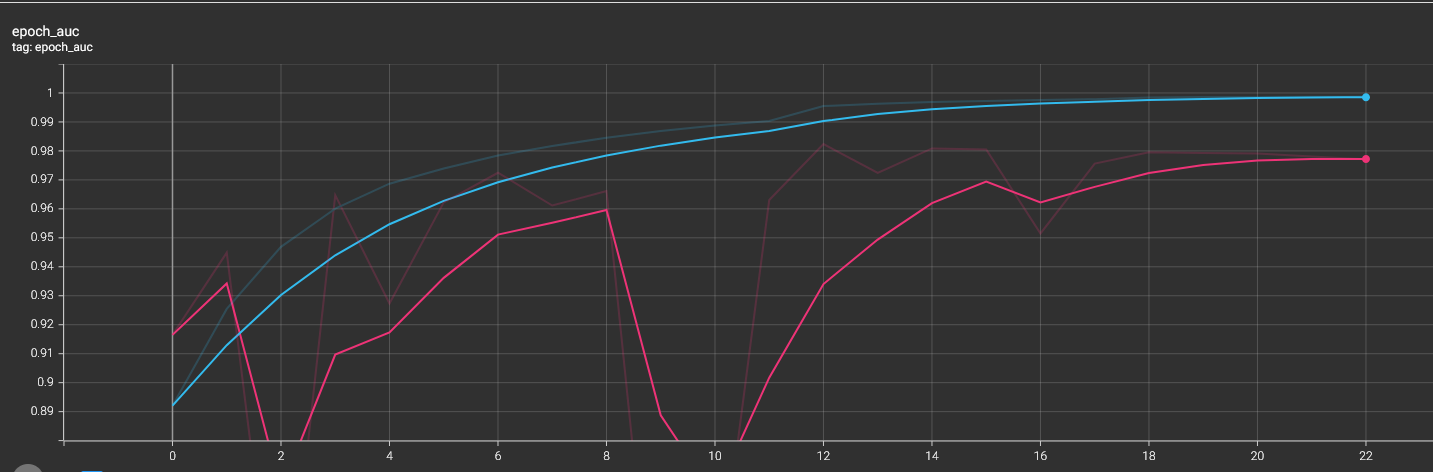

### 3.3.5 Results of different ideas

The initial architectural experiments yielded distinct performance outcomes on the validation set. The Area Under the Curve (AUC) metrics for each of these models are summarized in the table below:

| Model Naam                  | Best Validatie AUC  | Improvement (compared to baseline) |
|-----------------------------|-------------------------------|------------------------------------|
| CNN with 3 layers (Baseline) | 96,83%                        | -                                  |
| CNN with 4 layers        | 97,05%                        | 0,22%                              |
| CNN with strided net | 97,59%                        | 0,77%                              |
| CNN with BatchNormalisation               | 98,24%                        | 1,41%                              |

As evident from the table, the inclusion of Batch Normalization demonstrated the most significant positive impact on model performance during these initial comparisons.

# 4. Regularization and Performance Improvement

Following the initial architectural explorations, the focus shifted to implementing regularization techniques aimed at improving model generalization and preventing overfitting, particularly given the observation of training AUC approaching one while validation AUC remained lower.

## 4.1 Dropout for Regularization

Dropout was investigated as a key regularisation method. This technique, by randomly deactivating neurons during training, compels the network to develop more robust feature representations and effectively creates an ensemble of models. During inference, these multiple "voters" contribute to the final classification, which typically enhances generalisation.

Through experimentation with higher dropout rates in the baseline vanilla architecture, a notable stabilisation of the Area Under the Curve (AUC) was observed. This stabilisation is critical, as powerful networks can overfit to training noise, thereby diminishing their performance on unseen data. Specifically, while the training AUC continued to approach one, the validation AUC demonstrated greater stability, indicating improved generalisation rather than memorisation.

Given that two architectures—the 4-layer vanilla CNN and the CNN with Batch Normalisation—had previously shown potential for improved scores but also sensitivity to overfitting, these models were selected for further experimentation with increased dropout rates. 

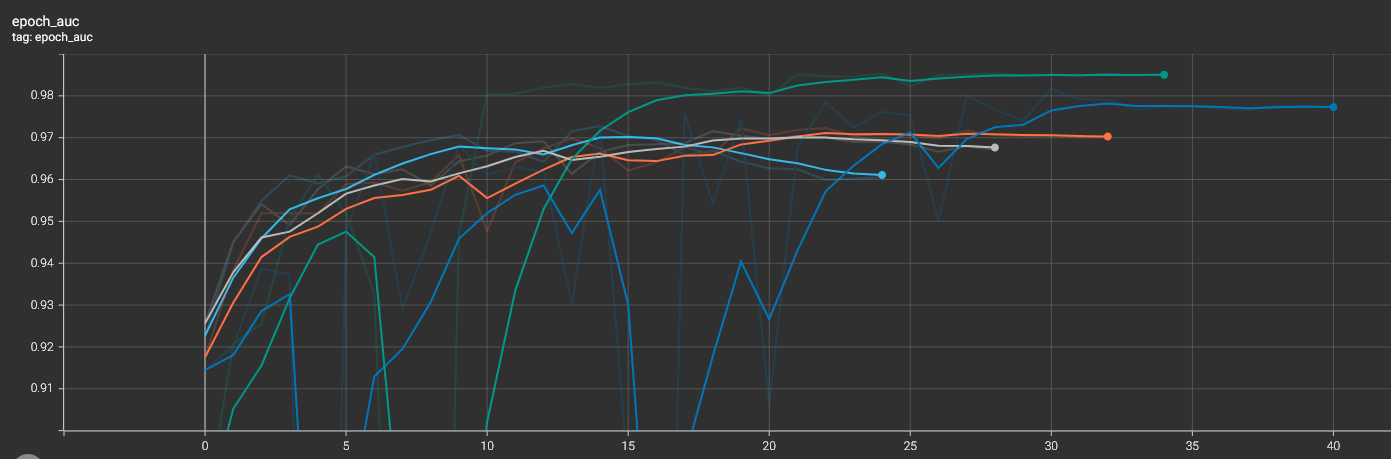

| Model Naam                  | Dropout | Best Validation AUC| Improvement (compared to 50% dropout) |
|-----------------------------|---------|-------------------------------|---------------------------------------|
| CNN with 3 layers           | 70%     | 97,16%                        | 0,33%                                 |
| CNN with 4 layers           | 90%     | 97,23%                        | 0,18%                                 |
| CNN with 4 layers           | 70%     | 97,28%                        | 0,23%                                 |
| CNN with BatchNormalisation | 70%     | 98,16%                        | -0,07%                                |
| CNN with BatchNormalisation | 90%     | 98,53%                        | 0,30%                                 |

## 4.2 Data Augmentation

While dropout significantly aided in improving training stability and generalisation, the persistent tendency for training AUC to approach one suggested that the model might still be memorising the training dataset. To address this, data augmentation was implemented as another powerful regularisation strategy to effectively expand the training dataset's diversity without collecting new images.

Instead of repeatedly presenting identical images from disk, the ImageDataGenerator was configured to apply on-the-fly transformations, such as rotations, horizontal and vertical flips, and brightness changes, to the training data during each epoch. This approach effectively multiplies the perceived size and variability of the training set by introducing diverse versions of existing images. This process inherently prevents the model from encoding specific training examples into its weights, forcing it to learn more generalised and robust features. The application of data augmentation notably contributed to an improved score and more stable training characteristics. 
TRhe result of this was a way more stable training and validation curve, and the test score staying away from a perfect score.

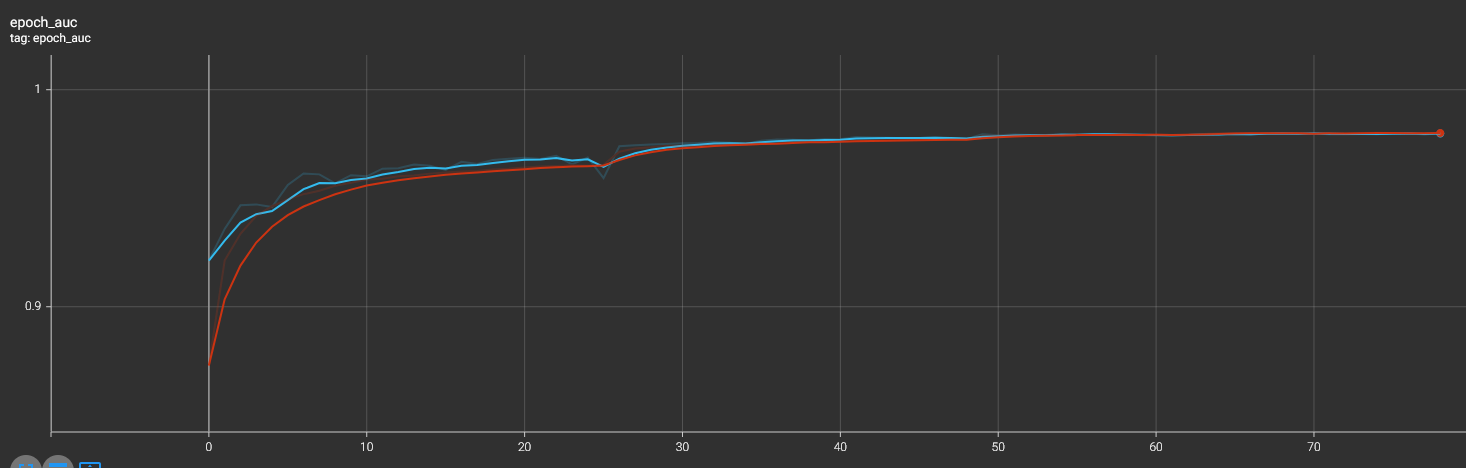

In [ ]:
datagen_augmented = ImageDataGenerator(
    rotation_range=90,          # Rotatie in stappen van 90 graden (0, 90, 180, 270)
    horizontal_flip=True,       # Willekeurig horizontaal spiegelen
    vertical_flip=True,         # Willekeurig verticaal spiegelen
    rescale=1./255,             # Normaliseren van pixelwaarden naar [0, 1]
    validation_split=0.2        # Percentage voor validatie dataset
)


# 3. trainings- en validatiedata genereren
# gebruik .flow_from_dataframe voor het koppelen van filenames aan labels
train_generator_augmented = datagen_augmented.flow_from_dataframe(
    dataframe=labels_df,
    directory=image_dir,
    x_col='image_name',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw', # 'raw' voor numerieke labels, 'categorical' voor one-hot encoded
    subset='training',
    shuffle=True,
    interpolation='nearest' # of 'bilinear'
)

validation_generator_augmented = datagen_augmented.flow_from_dataframe(
    dataframe=labels_df,
    directory=image_dir,
    x_col='image_name',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw', # 'raw' voor numerieke labels, 'categorical' voor one-hot encoded
    subset='validation',
    shuffle=False, # shuffle niet voor validatie
    interpolation='nearest'
)


# Run this with these settings:
# train_multiple_models(models_to_test, train_generator_augmented, validation_generator_augmented, epochs_to_train = 100)

# 5. Hyperparameter Optimization & Final Model Selection

This phase focused on systematically combining the most effective architectural enhancements and optimizing key hyperparameters to achieve the highest possible model performance and generalization.

## 5.1 Combining Promising Ideas

Based on the insights gained from the initial architectural explorations (Section 3) and regularisation experiments (Section 4), it became evident that several ideas contributed positively to model performance. To leverage these cumulative benefits, a new combined architecture was designed, integrating the following elements:

1. Batch Normalisation: Retained for its proven ability to stabilise training and accelerate convergence.
2. Strided Convolutional Layers: Implemented to replace traditional MaxPooling for downsampling, utilising its trainable parameters for potentially richer feature extraction.
3. Increased Network Depth: Expanded to include more layers, building on the observation that deeper networks showed improved performance in earlier tests.
4. Higher Dropout Rates: Incorporated to enhance regularisation and combat overfitting further, following the success observed in Section 4.1.
5. Augmented Training Data: Utilised throughout training to multiply dataset diversity and enforce more robust feature learning (as detailed in Section 4.2).

Given that these modifications operate at different levels of the network stack and target distinct aspects of training and generalisation, they were combined in a single, comprehensive architecture, assuming their positive effects would be synergistic.

In [ ]:
   
def conv_block_ideas_combined(input_tensor, filters, name_prefix):

    strides = (2,2)
    # Conv2D zonder activatie
    x = layers.Conv2D(filters, (3, 3), name=f'{name_prefix}_conv')(input_tensor)
    # Batch Normalization
    x = layers.BatchNormalization(name=f'{name_prefix}_bn')(x)
    # Activatie (bij voorkeur na Batch Normalization)
    x = layers.Activation('relu', name=f'{name_prefix}_relu')(x)
    # MaxPooling
    x = layers.Conv2D(filters, (3, 3), strides=strides, activation='relu', name=f'{name_prefix}_conv_block_ideas_combined')(x)
    return x

def create_cnn_with_ideas_combined(input_shape=(96, 96, 3), num_conv_blocks=3,
                               num_classes=1, dense_units=128, dropout_rate=0.5, model_name='cnn_batch_norm'):

    inputs = keras.Input(shape=input_shape, name='input_layer')
    x = inputs
    filters_start = 32

    for i in range(num_conv_blocks):
        current_filters = filters_start * (2 ** i)
        # Gebruikt de nieuwe conv_block_batch_norm
        x = conv_block_ideas_combined(x, current_filters, name_prefix=f'conv_block_{i+1}')

    outputs = classification_head(x, num_classes, dense_units, dropout_rate)
    model = Model(inputs=inputs, outputs=outputs, name=model_name)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

## 5.2 Hyperparameter Tuning with KerasTuner

With a more sophisticated combined network architecture, manual experimentation with various hyperparameter combinations would be highly inefficient and resource-intensive. Therefore, KerasTuner was employed to automate the search for an optimal configuration, explicitly targeting the number of convolutional blocks and the dropout rate.

The Hyperband tuner was chosen for its efficient resource allocation strategy. It iteratively trains a subset of hyperparameter combinations for varying numbers of epochs, pruning underperforming trials to focus computational resources on the most promising candidates. The optimisation objective was set to maximise val_auc (validation Area Under the Curve), with a maximum of 60 epochs.

The search space for the hyperparameters was defined as follows:

* num_conv_blocks: Explored an integer range from 3 to 4, allowing the tuner to identify optimal network depth within a focused range.
* dropout_rate: Tuned across a discrete set of values: 0.5, 0.7, 0.9, and 0.95, representing different levels of regularisation strength.

The build_model function was defined to construct the combined CNN architecture dynamically based on the hyperparameters suggested by the tuner. The tuner.search() function was then executed, leveraging the augmented training and validation data, with EarlyStopping and ReduceLROnPlateau callbacks managing the training of each trial. The tuner.results_summary() provided a comprehensive overview of the trials, their configurations, and their respective validation performance.

In [ ]:
def build_model(hp):

    input_shape=(96, 96, 3) # Vaste input shape
    num_classes=1         # Vaste output classes (voor binaire classificatie)

    inputs = keras.Input(shape=input_shape, name='input_layer')
    x = inputs
    filters_start = 32

    # Hyperparameter: Aantal convolutionele blokken
    # Zoekbereik: 3 tot 5 blokken (integers)
    num_conv_blocks = hp.Int('num_conv_blocks', min_value=3, max_value=4, step=1)

    for i in range(num_conv_blocks):
        current_filters = filters_start * (2 ** i)
        # Gebruikt de conv_block_ideas_combined functie
        x = conv_block_ideas_combined(x, current_filters, strides=(2,2), name_prefix=f'conv_block_{i+1}')

    # Hyperparameter: Dropout Rate in de classification head
    dropout_rate = hp.Choice('dropout_rate', values=[0.5, 0.7, 0.9, 0.95])

    # Vaste dense_units, indien dit geen hyperparameter is
    dense_units = 128

    # Gebruikt de classification_head functie
    outputs = classification_head(x, num_classes, dense_units, dropout_rate)
    model = Model(inputs=inputs, outputs=outputs, name='cnn_hyper_tuned_model')

    # Compileer het model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

MAX_TUNE_EPOCH=60

tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective('val_auc', direction='max'),
    max_epochs=MAX_TUNE_EPOCH,
    factor=3,
    directory='my_keras_tuner_dir_rerun',
    project_name='cnn_tuning_final'
)

# Je kunt nu tuner.search() aanroepen met je generators en custom callback
tuner.search(train_generator_augmented, epochs=MAX_TUNE_EPOCH, validation_data=validation_generator_augmented, callbacks=create_callbacks("Tuning_ideas", early_stopping_patience=5, reduce_lr_patience=3,))
tuner.results_summary()

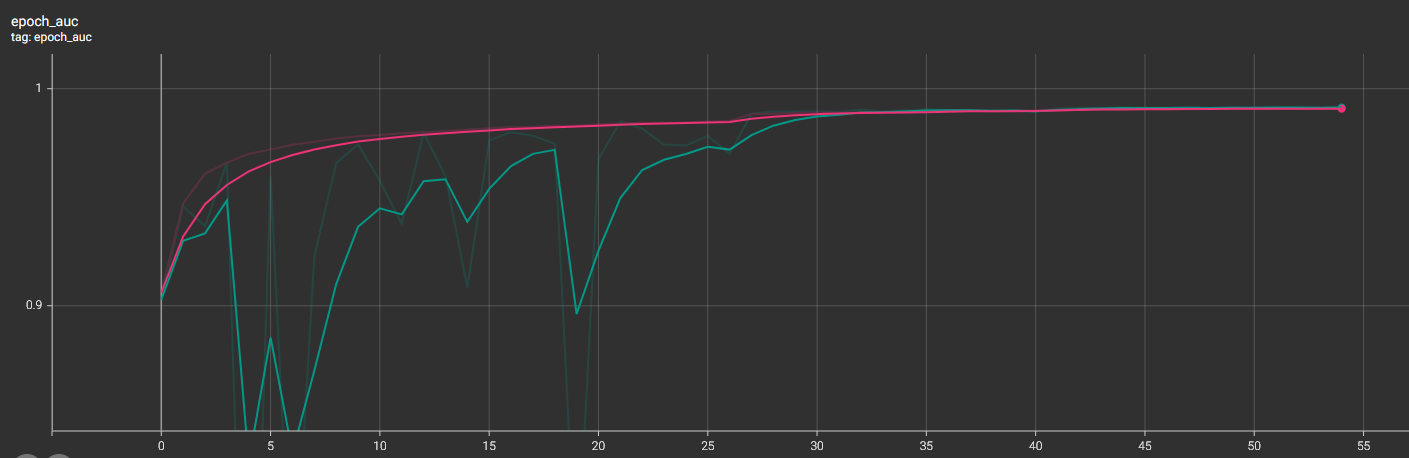

## 5.3 Final Model Training Strategy

The hyperparameter tuning process, specifically using KerasTuner, identified two architectures that demonstrated superior performance on the validation set. Both top-performing models featured 4 convolutional blocks. Interestingly, one model achieved a validation AUC of 0.95 with a dropout rate of 0.5, while another, with a higher dropout rate of 0.95, scored 0.938 after a comparable number of epochs. It is noteworthy that these top performers were at the opposite ends of the tested dropout range, with intermediate dropout values (0.7 and 0.9) yielding lower scores.

Recognizing that validation scores do not always perfectly predict performance on an unseen test set (a common observation in Kaggle competitions), a strategic decision was made to train both of these promising models until full completion, allowing them to converge fully. While the model with 0.95 dropout initially scored slightly lower on the validation set, it was hypothesized that higher dropout rates might require more training epochs to fully converge, potentially leading to a more robust and powerful model. Furthermore, increased dropout effectively creates an ensemble of models during training, and a more diverse ensemble might generalize better to new data. This dual training strategy aimed to maximize the chances of achieving optimal performance on the final competition dataset.

## 5.4 Submission code

Following the training and selection of the final models, the next step involved generating predictions on the unlabeled test dataset provided by the Kaggle competition. The test_generator was configured to load these images without shuffling and with class_mode='input' to retrieve only the image data.

The best-performing model (identified as CNN_Maxpool_augmented_layers_4_DO_05.keras based on previous training runs and hyperparameter tuning results) was loaded from its saved state. Predictions were then generated for all images in the test set.

Finally, these raw predictions (probabilities) were converted into binary labels (0 or 1) using a threshold of 0.5. The resulting image IDs and their corresponding predicted labels were compiled into a Pandas DataFrame and saved as a CSV file (submission_05_dropout.csv), formatted precisely for submission to the Kaggle competition. This file represents the final output of the developed model on the unseen test data.

In [ ]:
test_generator = datagen.flow_from_directory(
    directory="test/",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='input',
    shuffle=False, 
    interpolation='nearest'
)
print(f"testdata batches: {len(test_generator)}")
test_image_filenames = test_generator.filenames

model = tf.keras.models.load_model("saved_models/CNN_Maxpool_augmented_layers_4_DO_05.keras")
predictions = model.predict(test_generator)


# Controleer of het aantal bestandsnamen overeenkomt met het aantal voorspellingen
if len(test_image_filenames) != len(predictions):
    raise ValueError("Het aantal bestandsnamen komt niet overeen met het aantal voorspellingen.")

# Combineer bestandsnamen en voorspellingen
results = []
for i, filename in enumerate(test_image_filenames):
    base_filename = os.path.basename(filename) # Haalt '00006537328c33e284c973d7b39d340809f7271b.tif' op

    # Extract ID: alles vóór de '.tif' extensie
    extracted_id = os.path.splitext(base_filename)[0] # Splitst de extensie af

    # Haal de voorspelling op
    prediction_value = predictions[i]
    if prediction_value[0] > 0.5:
        label = 1
    else:
        label = 0
    results.append({'id': extracted_id, 'label': label})

# Maak een DataFrame
df_results = pd.DataFrame(results)

# Print de eerste rijen van het DataFrame
print("DataFrame met resultaten (eerste 5 rijen):")
print(df_results.head())

# Optioneel: Sla het DataFrame op als een CSV-bestand
output_csv_filename = "submission_05_dropout.csv"
df_results.to_csv(output_csv_filename, index=False)
print(f"\nResultaten opgeslagen in '{output_csv_filename}'")

# 6. Results and Analysis

This section provides an overarching analysis of the model development process, synthesizing the findings from the architectural explorations, regularization attempts, and hyperparameter tuning. The goal is to interpret the experimental outcomes, discuss the effectiveness of different strategies, and identify the most impactful improvements.

## 6.1 Overall Performance Summary

Throughout the iterative development process, several models demonstrated strong performance. The best-performing configurations consistently achieved high validation Area Under the Curve (AUC) scores, indicating their strong capability in distinguishing between cancerous and non-cancerous image patches. The highest validation AUC observed was **98.53%** with a Batch Normalization architecture utilizing 90% dropout.

## 6.2 Analysis of Architectural Improvements

The initial architectural explorations, as detailed in Section 3.3, revealed clear insights into effective CNN design for this task:

* **Baseline Performance:** The initial 3-layer Vanilla CNN served as a foundational benchmark.
* **Impact of Additional Layers:** Increasing the network depth to four layers yielded a marginal improvement in AUC (0.22% over baseline), suggesting that increased capacity was beneficial to a certain extent.
* **Strided Convolutions vs. MaxPooling:** Replacing MaxPooling with strided convolutions resulted in a more significant gain (0.77% improvement over baseline). This indicates that allowing the network to learn downsampling through trainable parameters, rather than fixed pooling operations, provided a more optimized feature representation.
* **Batch Normalization:** The most substantial improvement in early architectural tests came from the inclusion of Batch Normalization, which boosted the AUC by 1.41% over the baseline. Batch Normalization proved highly effective in stabilizing network training, likely by normalizing feature distributions and allowing for higher learning rates, leading to faster convergence and better overall performance.

## 6.3 Impact of Regularization Techniques

Regularization strategies were crucial in improving the models' generalization capabilities and preventing overfitting, especially given the tendency for training AUC to approach 1.0.

* **Dropout Effectiveness:** Experimentation with various dropout rates in Section 4.1 significantly impacted model stability and generalization. While high training AUC indicated the model's capacity to learn the training data extensively, appropriate dropout rates (e.g., 90% on the Batch Normalization model) were effective in maintaining a stable validation AUC and bridging the gap between training and validation performance. This validated dropout's role in forcing the network to learn more robust features by creating an ensemble effect during training.
* **Data Augmentation Contributions:** As discussed in Section 4.2, data augmentation further enhanced regularization by artificially expanding the training dataset. By dynamically transforming images (rotation, flips, brightness changes), the model was prevented from memorizing specific training examples and instead learned more generalized patterns. This contributed to preventing the training AUC from reaching excessive values too quickly and resulted in improved overall scores.

## 6.4 Hyperparameter Optimization Summary

KerasTuner was instrumental in systematically exploring the hyperparameter space for the combined architecture, optimizing for `val_auc`. The Hyperband tuner efficiently identified promising configurations.

* **Optimal Hyperparameters:** The tuning process highlighted that models with **4 convolutional blocks** consistently performed best. For dropout, the best results were found at the extremes of the tested range: a dropout rate of **0.5** yielded an AUC of 0.95, while a rate of **0.95** achieved 0.938 AUC. This surprising finding suggests that either a moderate amount of regularization (0.5) or a very aggressive one (0.95) was most effective, potentially due to the higher dropout forcing the model into a more robust ensemble learning mode, albeit possibly requiring more epochs to fully converge.
* **Final Training Strategy:** Recognising that validation scores do not always perfectly predict performance on an unseen test set (a common observation in Kaggle competitions), the top-performing models, particularly those identified by KerasTuner, were selected for full training completion. This strategy aimed to maximise their convergence and leverage the full potential of higher dropout rates, which might require more training time to yield their full benefits on the final test set.

## 6.5 Troubleshooting and Challenges

During the development process, common deep learning challenges such as initial overfitting were observed, particularly when regularisation techniques were not yet fully implemented. Debugging focused on monitoring learning curves to detect performance plateaus or divergence, which guided the iterative application of techniques like Batch Normalisation and Dropout. Ensuring proper data loading and generator functionality was also a recurring, albeit minor, aspect of troubleshooting.

However, the most significant challenge proved to be bridging the gap between performance on the validation set and the unseen competition test set. The drastically lower Kaggle score of 0.8310 (public) and 0.8089 (private) compared to the high validation AUC of 0.9853  indicates deeper generalisation issues that initial monitoring via learning curves did not fully capture.

## 6.6 Kaggle Leaderboard Performance

The final submission to the Kaggle competition, based on the `CNN_Maxpool_augmented_layers_4_DO_05.keras` model , achieved a public leaderboard AUC score of 0.8310. The private score was 0.8089. This score was significantly lower than the highest validation AUCs (up to 98.53%) observed during training.

This difference indicates reduced generalisation to the unseen test data, which may suggest:

- Overfitting: Despite applied regularisation techniques (dropout, data augmentation), the model might still have overfitted to the validation set.
- Dataset Discrepancies: There may be subtle differences in feature distribution between the validation and competition test sets, resulting in a decrease in performance on the latter.

Further analysis of the test set and potential improvements are necessary to bridge this performance gap.

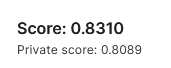
*Screenshot with Kaggle score*

# 7. Conclusion

This project successfully implemented and iterated on various convolutional neural network architectures for histopathologic cancer detection, addressing the binary image classification challenge.

Key takeaways from the experimental process include:
* **Data Quality:** The provided dataset was of high quality, requiring minimal cleaning beyond standard preprocessing.
* **Architectural Impact:** The strategic inclusion of Batch Normalisation proved to be the most significant architectural improvement in the early stages, leading to substantial performance gains and training stability. Replacing MaxPooling with strided convolutions also yielded positive, albeit smaller, benefits.
* **Regularisation is Critical:** Both Dropout and Data Augmentation were essential in combating overfitting and improving the model's ability to generalise to unseen data. Dropout particularly helped stabilise AUC, while augmentation effectively expanded the dataset's diversity, preventing the model from merely memorising training examples.
* **Automated Tuning Value:** KerasTuner efficiently identified optimal hyperparameter combinations, affirming the benefit of automated search over manual grid searches, especially for complex architectures.
* **Generalisation Challenges:** The substantial drop in performance from validation to test set (from ~98% AUC to ~81% AUC ) highlights the critical need for more robust generalisation techniques and a more rigorous validation strategy. This strongly suggests overfitting to the validation set, or a distribution shift between the validation and the truly unseen test data.

While the developed models demonstrated strong performance in the training phase, potential avenues to bridge the gap include:
* **Transfer Learning:** Exploring pre-trained models on large image datasets (e.g., ImageNet) such as ResNet or Inception, and fine-tuning them for this specific task, which could potentially help in learning more robust, generalised features that are less sensitive to the specific training data..
* **Ensemble Methods:** Explicitly combining predictions from multiple diverse top-performing models to potentially achieve even higher accuracy and robustness. Especially if these models have different characteristics of over-fitting.
* **More Robust Validation:** The discrepancy between validation and test scores underscores the necessity of k-fold cross-validation or a more representative dataset split to gain a more reliable assessment of generalisation performance.
* **Advanced Augmentation:** Investigating more complex augmentation techniques (e.g., Mixup, CutMix) or more aggressive transformations to further enhance robustness and increase the effective diversity of the training data.
* **Dataset Difference Analysis:** A diagnostic step, such as classifying whether an image belongs to the training or test set, could provide insight into the degree and nature of any dataset shifts.